In [1]:
#import statements
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer,RobustScaler,MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import env
import get_function as gf

**Aquire**

In [2]:
# Import from zillow
df = gf.get_zillow_data()

In [3]:
df.head()

,parcelid,logerror,transactiondate,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,12177905,-0.103410,2017-01-01,2288172,12177905,NaN,None,None,3.0,4.0,...,NaN,None,108918.0,145143.0,2016.0,36225.0,1777.51,None,NaN,6.037300e+13
1,12095076,-0.001011,2017-01-01,781532,12095076,1.0,None,None,3.0,4.0,...,NaN,None,276684.0,773303.0,2016.0,496619.0,9516.26,None,NaN,6.037461e+13
2,12069064,0.101723,2017-01-01,870991,12069064,NaN,None,None,1.0,2.0,...,NaN,None,18890.0,218552.0,2016.0,199662.0,2366.08,None,NaN,6.037302e+13
3,12790562,-0.040966,2017-01-02,1246926,12790562,NaN,None,None,3.0,4.0,...,NaN,None,177527.0,220583.0,2016.0,43056.0,3104.19,None,NaN,6.037500e+13
4,11104527,0.005963,2017-01-02,1639362,11104527,1.0,None,None,3.0,4.0,...,NaN,None,271715.0,430108.0,2016.0,158393.0,6103.36,None,NaN,6.037920e+13


**Prepare**

In [4]:
# dropp columns with less than 60% of data non-null and rows with more than 75% of data non-null
df = gf.handle_missing_values(df, prop_required_column = .6, prop_required_row = .75)

In [5]:
# removing unnessesery columns
df = gf.remove_columns(df, ['roomcnt','assessmentyear','unitcnt','regionidzip','regionidcounty','propertylandusetypeid','propertycountylandusecode','fullbathcnt','calculatedbathnbr','rawcensustractandblock','finishedsquarefeet12','parcelid','transactiondate','id','regionidcity','buildingqualitytypeid','heatingorsystemtypeid','propertyzoningdesc','censustractandblock'])

In [6]:
df = df.rename(columns={'lotsizesquarefeet':'lot_square_feet','calculatedfinishedsquarefeet':'home_square_feet', 'logerror': 'target','bathroomcnt': 'bathroom', 'bedroomcnt': 'bedroom','structuretaxvaluedollarcnt':'structure_value','taxvaluedollarcnt': 'total_value','landtaxvaluedollarcnt':'land_value','taxamoun':'tax_amount','taxamount':'tax_amount','yearbuilt':'year_built'})

In [7]:
# Covert year built into age years

df['age']= 2017 - df.year_built

# Drop year built because we added age column

df.drop(columns='year_built',inplace=True)

In [8]:
# Split data (train & test)

train, test = gf.split_my_data(df, .80, 123)

In [9]:
# impute lot_square_feet,structure_value, and tax_amount for the mean

train = gf.imputer_9000(train,['lot_square_feet','structure_value','tax_amount', 'age'],'mean')
test = gf.imputer_9000(test,['lot_square_feet','structure_value','tax_amount', 'age'],'mean')

In [10]:
train['home_value_square_footage'] = train.structure_value/train.home_square_feet
train['land_value_square_footage'] = train.land_value/train.lot_square_feet

test['home_value_square_footage'] = test.structure_value/test.home_square_feet
test['land_value_square_footage'] = test.land_value/test.lot_square_feet

In [11]:
train.isnull().sum()

target                       0
bathroom                     0
bedroom                      0
home_square_feet             0
fips                         0
latitude                     0
longitude                    0
lot_square_feet              0
structure_value              0
total_value                  0
land_value                   0
tax_amount                   0
age                          0
home_value_square_footage    0
land_value_square_footage    0
dtype: int64

In [12]:
test.isnull().sum()

target                       0
bathroom                     0
bedroom                      0
home_square_feet             0
fips                         0
latitude                     0
longitude                    0
lot_square_feet              0
structure_value              0
total_value                  0
land_value                   0
tax_amount                   0
age                          0
home_value_square_footage    0
land_value_square_footage    0
dtype: int64

In [13]:
# Scale age, latitude, and longitude using MinMax scaler - why (to presrve distance better, and not distort correlation)

train = gf.scaler_min_max(train, ['age', 'latitude', 'longitude', 'land_value_square_footage', 'home_value_square_footage'])
test = gf.scaler_min_max(test, ['age', 'latitude', 'longitude', 'land_value_square_footage', 'home_value_square_footage'])

In [14]:
# Scale bathroom, bedroom, home_square_feet, lot_square_feet, structure_value, total_value, land_value, tax_amount using uniform scaler

# Scale columns using Uniform scaler (to smooth out the distribution and handle outliers)

train = gf.uniform_scaler(train,['bathroom', 'bedroom', 'home_square_feet', 'lot_square_feet', 'structure_value', 'total_value', 'land_value', 'tax_amount'])
test = gf.uniform_scaler(test,['bathroom', 'bedroom', 'home_square_feet', 'lot_square_feet', 'structure_value', 'total_value', 'land_value', 'tax_amount'])

In [15]:
train.head()

,target,fips,age,latitude,longitude,land_value_square_footage,home_value_square_footage,bathroom,bedroom,home_square_feet,lot_square_feet,structure_value,total_value,land_value,tax_amount
27330,0.002157,6037.0,0.395522,0.557000,0.285832,0.017275,0.058223,0.474747,0.439394,0.873672,0.839560,0.795914,0.866593,0.879433,0.863241
12260,-0.053258,6037.0,0.462687,0.359512,0.402151,0.004009,0.014283,0.474747,0.439394,0.545455,0.119727,0.070707,0.132333,0.257921,0.116210
27165,-0.027946,6037.0,0.044776,0.889853,0.516559,0.000881,0.011971,0.808081,0.439394,0.749439,0.767824,0.084252,0.060612,0.092274,0.570231
27296,0.036370,6037.0,0.664179,0.514136,0.517688,0.055174,0.094028,0.000000,0.111111,0.014805,0.009555,0.375978,0.699622,0.776588,0.676910
6387,-0.000858,6037.0,0.238806,0.353049,0.413865,0.073855,0.072092,0.808081,0.439394,0.728758,0.010566,0.770683,0.848893,0.865827,0.841041


**Exploration**

In [16]:
# analysis, t-test, visualization

In [17]:
# Exploring overestimits versus underestimits

In [18]:
# mean of all overestimits
train.target[train.target > 0].mean()

0.081850353460498

In [19]:
# mean of all underestimits
train.target[train.target < 0].mean()

-0.06776640057920577

In [20]:
train.target[train.target > 0].count() /(train.target[train.target > 0].count() + train.target[train.target < 0].count())

0.5522626112759644

Differinces in over and underestimation

over mean = .081

over %56

under mean = -.068

under %44

In [21]:
# Added to look for corrilation between variables and total log error irrespective of over or under estimation
train['absolute_target']= train.target.abs() 

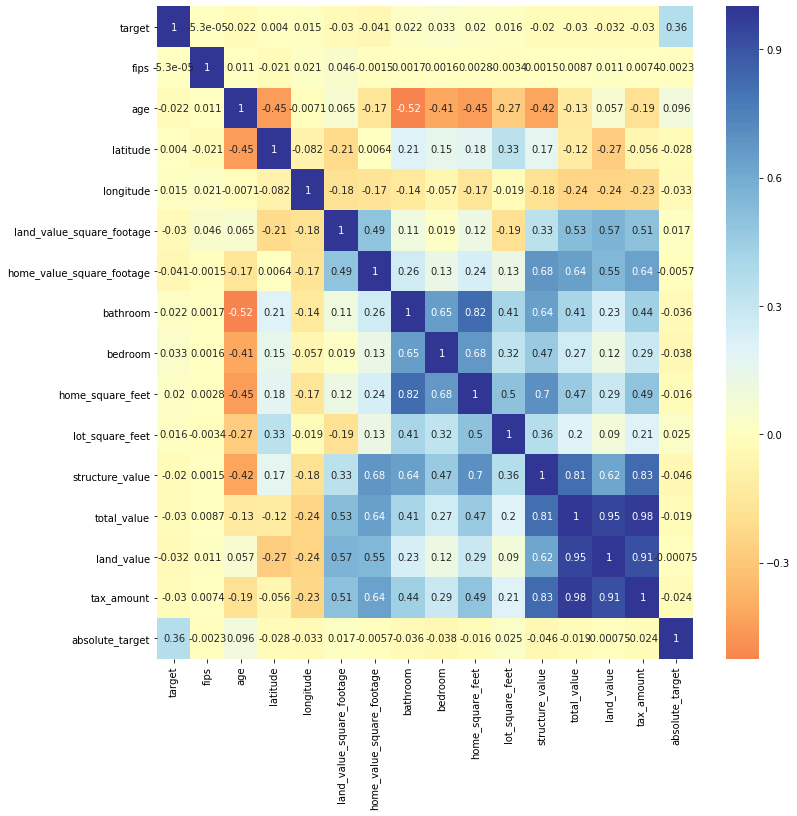

In [22]:
#heatmap for correlation
plt.figure(figsize=(12,12))
sns.heatmap(train.corr(), cmap='RdYlBu', annot=True, center=0)

In [23]:
# plt.figure(figsize=(22,22))
# sns.pairplot(train)
# plt.show()

In [24]:
# # home_value_square_footage and land_value_square_footage showed the most potential for explaning the targe 
# plt.figure(figsize=(22,22))
# sns.pairplot(train[['target', 'home_value_square_footage','land_value_square_footage']])
# plt.show()

In [25]:
# droped dot to little value
train.drop(columns='absolute_target',inplace=True)

home_value_square_footage and land_value_square_foortage show a correlation with logerror

Going to try correlating home_value_square_footage and land_value_square_foortage

In [26]:
# dropping fips column to avoid noise
train = train.drop(columns=['fips','latitude','longitude'])

In [27]:
# Perform a baseline
train['y_base']= train.target.mean()

**Baseline Model**

In [28]:
# Baseline using target mean
x = train[['y_base']]
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns=['yhat','y_base'],inplace=True)

SSE:  773.667932212638 MSE:  0.028696881758629007 RMSE:  0.16940154001256602


In [29]:
# baseline using all starting features
x = train.drop(columns=['land_value_square_footage','home_value_square_footage','target'])
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  770.6964631078371 MSE:  0.028586664061863394 RMSE:  0.16907591212784687


## Cluster

   k        sse
0  1  67.033946
1  2  39.767134
2  3  26.500678
3  4  20.081390
4  5  16.139411
5  6  13.526938
6  7  11.470372
7  8   9.954371
8  9   8.668910


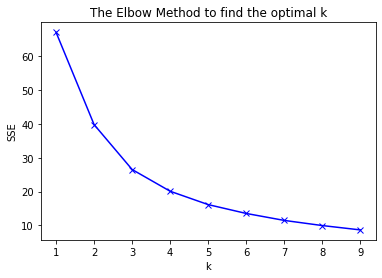

In [30]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train[['home_value_square_footage','land_value_square_footage']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

**K = 5**

In [31]:
# List of features
cluster_columns = ['home_value_square_footage', 'land_value_square_footage']

#make the clusters
kmeans = KMeans(n_clusters=5, n_init =1, random_state=123).fit(train[cluster_columns])

#add clusters back to df
train['cluster'] = kmeans.predict(train[cluster_columns])

# find ave of the cluster columns
cluster_means = train.groupby('cluster')[cluster_columns].transform('mean')

# rename columns
cluster_means.columns = ['avg_home_value_square_footage', 'avg_land_value_square_footage']

# rejoin original dataframe
train = train.join(cluster_means)

In [32]:
# create model basesd on only cluster variables
x = train[['avg_home_value_square_footage', 'avg_land_value_square_footage']]
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  772.2939020370583 MSE:  0.028645916247665368 RMSE:  0.16925104504157534


In [33]:
# create model basesd on using all features except those columns used to create clusters
x = train.drop(columns = ['target','cluster','land_value','structure_value','home_square_feet','lot_square_feet'])
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  770.67768941409 MSE:  0.028585967708237757 RMSE:  0.16907385282248039


In [34]:
#Resetting train for new test at k =  4
train.drop(columns=['cluster','avg_home_value_square_footage','avg_land_value_square_footage'],inplace=True)

## K = 4

In [35]:

# List of features
cluster_columns = ['home_value_square_footage', 'land_value_square_footage']

#make the clusters
kmeans = KMeans(n_clusters= 4, n_init =1, random_state=123).fit(train[cluster_columns])

#add clusters back to df
train['cluster'] = kmeans.predict(train[cluster_columns])

# find ave of the cluster columns
cluster_means = train.groupby('cluster')[cluster_columns].transform('mean')

# rename columns
cluster_means.columns = ['avg_home_value_square_footage', 'avg_land_value_square_footage']

# rejoin original dataframe
train = train.join(cluster_means)

In [36]:
# create model basesd on using all features except those columns used to create clusters
x = train.drop(columns = ['target','cluster','land_value','structure_value','home_square_feet','lot_square_feet'])
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  770.5534526734585 MSE:  0.028581359520528878 RMSE:  0.16906022453708286


In [37]:
#Resetting train for new test at k =  4
train.drop(columns=['cluster','avg_home_value_square_footage','avg_land_value_square_footage'],inplace=True)

## K = 6

In [38]:
# List of features
cluster_columns = ['home_value_square_footage', 'land_value_square_footage']

#make the clusters
kmeans = KMeans(n_clusters= 6, n_init =1, random_state=123).fit(train[cluster_columns])

#add clusters back to df
train['cluster'] = kmeans.predict(train[cluster_columns])

# find ave of the cluster columns
cluster_means = train.groupby('cluster')[cluster_columns].transform('mean')

# rename columns
cluster_means.columns = ['avg_home_value_square_footage', 'avg_land_value_square_footage']

# rejoin original dataframe
train = train.join(cluster_means)

In [39]:
# create model basesd on using all features except those columns used to create clusters
x = train.drop(columns = ['target','cluster','land_value','structure_value','home_square_feet','lot_square_feet'])
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  770.6671910800603 MSE:  0.02858557830415654 RMSE:  0.16907270123871726


## k = 4 shows marginally better results

## Using OLS model swaped with swapped features on test data

In [40]:
# transformed test dataframe to match columns in train set
test.drop(columns= ['fips', 'latitude', 'longitude'], inplace=True)

In [41]:
# List of features
cluster_columns = ['home_value_square_footage', 'land_value_square_footage']

#make the clusters
kmeans = KMeans(n_clusters= 4, n_init =1, random_state=123).fit(test[cluster_columns])

#add clusters back to df
test['cluster'] = kmeans.predict(test[cluster_columns])

# find ave of the cluster columns
cluster_means = test.groupby('cluster')[cluster_columns].transform('mean')

# rename columns
cluster_means.columns = ['avg_home_value_square_footage', 'avg_land_value_square_footage']

# rejoin original dataframe
test = test.join(cluster_means)


In [42]:
# create model basesd on using all features except those columns used to create clusters
x = train.drop(columns = ['target','cluster','land_value','structure_value','home_square_feet','lot_square_feet'])
y = train[['target']]

regr = ols('y ~ x', data = train).fit()

train['yhat'] = regr.predict(x)

SSE, MSE, RMSE = gf.regression_errors(y,train.yhat, train)

train.drop(columns='yhat',inplace=True)

SSE:  770.6671910800603 MSE:  0.02858557830415654 RMSE:  0.16907270123871726
